Device: cuda


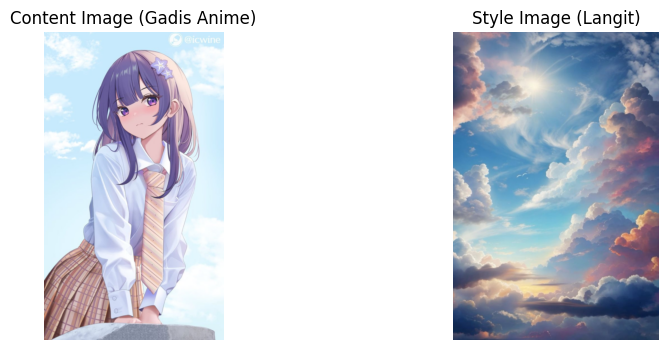

Step 0, Loss: 144136064.0
Step 50, Loss: 23468616.0
Step 100, Loss: 18072532.0
Step 150, Loss: 15673848.0
Step 200, Loss: 14095568.0
Step 250, Loss: 12936204.0


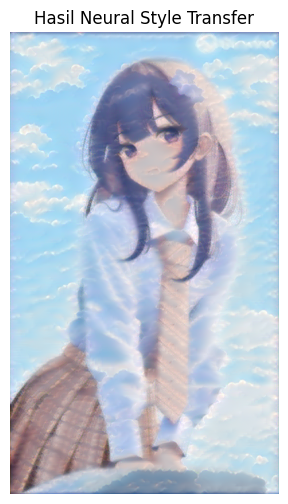

✅ Hasil disimpan sebagai hasil_nst.png


In [3]:
# ================================
# 1. IMPORT LIBRARY
# ================================
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.models import vgg19, VGG19_Weights
from PIL import Image
import matplotlib.pyplot as plt

# ================================
# 2. SET DEVICE
# ================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ================================
# 3. LOAD & PREPROCESS IMAGE
# ================================
def load_image(image_path, max_size=400):
    image = Image.open(image_path).convert("RGB")
    size = max_size if max(image.size) > max_size else max(image.size)

    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor()
    ])

    image = transform(image).unsqueeze(0)
    return image.to(device)

# ================================
# 4. LOAD CONTENT & STYLE IMAGE
# ================================
content = load_image("Ei.jpeg")
style = load_image("Sky.jpeg")

# ================================
# 5. TAMPILKAN GAMBAR AWAL
# ================================
content_show = content.cpu().squeeze().permute(1,2,0)
style_show   = style.cpu().squeeze().permute(1,2,0)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(content_show)
plt.title("Content Image (Gadis Anime)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(style_show)
plt.title("Style Image (Langit)")
plt.axis("off")

plt.show()

# ================================
# 6. LOAD VGG19 MODEL
# ================================
vgg = vgg19(weights=VGG19_Weights.DEFAULT).features.to(device).eval()

# ================================
# 7. GRAM MATRIX FUNCTION
# ================================
def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    tensor = tensor.view(c, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

# ================================
# 8. FEATURE EXTRACTION
# ================================
content_layer = '21'
style_layers = ['0', '5', '10', '19', '28']

def get_features(image, model):
    features = {}
    x = image

    for name, layer in model._modules.items():
        x = layer(x)
        if name in style_layers:
            features[name] = x
        if name == content_layer:
            features['content'] = x

    return features

# ================================
# 9. INITIAL GENERATED IMAGE
# ================================
generated = content.clone().requires_grad_(True)

# ================================
# 10. OPTIMIZER
# ================================
optimizer = optim.Adam([generated], lr=0.003)

# ================================
# 11. TRAINING LOOP
# ================================
for step in range(300):
    gen_features     = get_features(generated, vgg)
    content_features = get_features(content, vgg)
    style_features   = get_features(style, vgg)

    # Content Loss
    content_loss = torch.mean(
        (gen_features['content'] - content_features['content']) ** 2
    )

    # Style Loss
    style_loss = 0
    for layer in style_layers:
        gen_gram   = gram_matrix(gen_features[layer])
        style_gram = gram_matrix(style_features[layer])
        style_loss += torch.mean((gen_gram - style_gram) ** 2)

    # Total Loss
    total_loss = 1e5 * content_loss + style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if step % 50 == 0:
        print(f"Step {step}, Loss: {total_loss.item()}")

# ================================
# 12. TAMPILKAN HASIL AKHIR
# ================================
result = generated.detach().cpu().squeeze().permute(1,2,0)

plt.figure(figsize=(6,6))
plt.imshow(result)
plt.title("Hasil Neural Style Transfer")
plt.axis("off")
plt.show()

# ================================
# 13. SIMPAN HASIL
# ================================
plt.imsave("hasil_nst.png", result)
print("✅ Hasil disimpan sebagai hasil_nst.png")
